# 03 - Video Deepfake Detection Baseline

## Objective
Compare video-based deepfake detection models:
- **TimeSformer** - Space-time attention for video understanding
- **VideoMAE** - Masked autoencoding for video
- **3D ResNet** - Spatio-temporal CNNs
- **LSTM on Frame Features** - Temporal modeling baseline

## Dataset
Using DFD (DeepFake Detection) dataset with extracted faces:
- Train: `../dfd_faces/train/`
- Test: `../dfd_faces/test/`

## Approach
1. Extract face sequences from videos
2. Apply temporal models to detect inconsistencies
3. Compare performance across architectures

In [1]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch: 2.9.1+cu128
CUDA Available: True
GPU: NVIDIA RTX A6000
GPU Memory: 48.31 GB


In [3]:
!pip install -q transformers timm opencv-python
!pip install -q matplotlib seaborn tqdm scikit-learn
!pip install -q decord 

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Video and image processing
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torchvision.models.video as video_models

# Transformers
from transformers import (
    VideoMAEModel, VideoMAEImageProcessor,
    TimesformerModel, AutoImageProcessor
)

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

C:\Users\akshay-stu\miniconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [6]:
# Dataset paths (using pre-extracted faces)
TRAIN_FAKE_DIR = '../dfd_faces/train/fake'
TRAIN_REAL_DIR = '../dfd_faces/train/real'
TEST_FAKE_DIR = '../dfd_faces/test/fake'
TEST_REAL_DIR = '../dfd_faces/test/real'

# Video parameters
IMG_SIZE = 224
NUM_FRAMES = 16  # Number of frames to sample from each video
FRAME_SKIP = 2   # Skip frames for temporal diversity

# Training parameters
BATCH_SIZE = 4   # Smaller due to video memory requirements
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

print("Configuration set!")

Configuration set!


In [10]:
class FaceSequenceDataset(Dataset):
    """Dataset for loading face image sequences from video folders"""
    def __init__(self, fake_dir, real_dir, num_frames=16, transform=None):
        self.num_frames = num_frames
        self.transform = transform
        self.video_folders = []
        self.labels = []
        
        # Load fake video folders
        if os.path.exists(fake_dir):
            for folder_name in os.listdir(fake_dir):
                folder_path = os.path.join(fake_dir, folder_name)
                if os.path.isdir(folder_path):
                    # Check if folder has enough frames
                    frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
                    if len(frames) >= num_frames:
                        self.video_folders.append(folder_path)
                        self.labels.append(1)  # fake
        
        # Load real video folders
        if os.path.exists(real_dir):
            for folder_name in os.listdir(real_dir):
                folder_path = os.path.join(real_dir, folder_name)
                if os.path.isdir(folder_path):
                    frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
                    if len(frames) >= num_frames:
                        self.video_folders.append(folder_path)
                        self.labels.append(0)  # real
        
        print(f"Loaded {len(self.video_folders)} video sequences: {self.labels.count(0)} real, {self.labels.count(1)} fake")
    
    def __len__(self):
        return len(self.video_folders)
    
    def __getitem__(self, idx):
        folder_path = self.video_folders[idx]
        label = self.labels[idx]
        
        # Get all frame files
        frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
        
        # Sample frames uniformly
        total_frames = len(frame_files)
        if total_frames >= self.num_frames:
            # Uniform sampling
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            sampled_files = [frame_files[i] for i in indices]
        else:
            # Not enough frames (shouldn't happen due to filtering)
            sampled_files = frame_files[:self.num_frames]
        
        # Load frames
        frames = []
        for frame_file in sampled_files:
            frame_path = os.path.join(folder_path, frame_file)
            try:
                img = Image.open(frame_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                frames.append(img)
            except Exception as e:
                # Use black frame on error
                frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
        
        # Pad if needed
        while len(frames) < self.num_frames:
            frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
        
        # Stack frames: (num_frames, C, H, W)
        frames_tensor = torch.stack(frames)
        return frames_tensor, label

print("Dataset class defined!")

Dataset class defined!


In [11]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined!")

Transforms defined!


In [12]:
print("Loading training data...")
train_dataset = FaceSequenceDataset(TRAIN_FAKE_DIR, TRAIN_REAL_DIR, NUM_FRAMES, train_transform)

print("\nLoading test data...")
test_dataset = FaceSequenceDataset(TEST_FAKE_DIR, TEST_REAL_DIR, NUM_FRAMES, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading training data...
Loaded 488 video sequences: 232 real, 256 fake

Loading test data...
Loaded 153 video sequences: 73 real, 80 fake

Train batches: 122
Test batches: 39


Showing sample sequences...


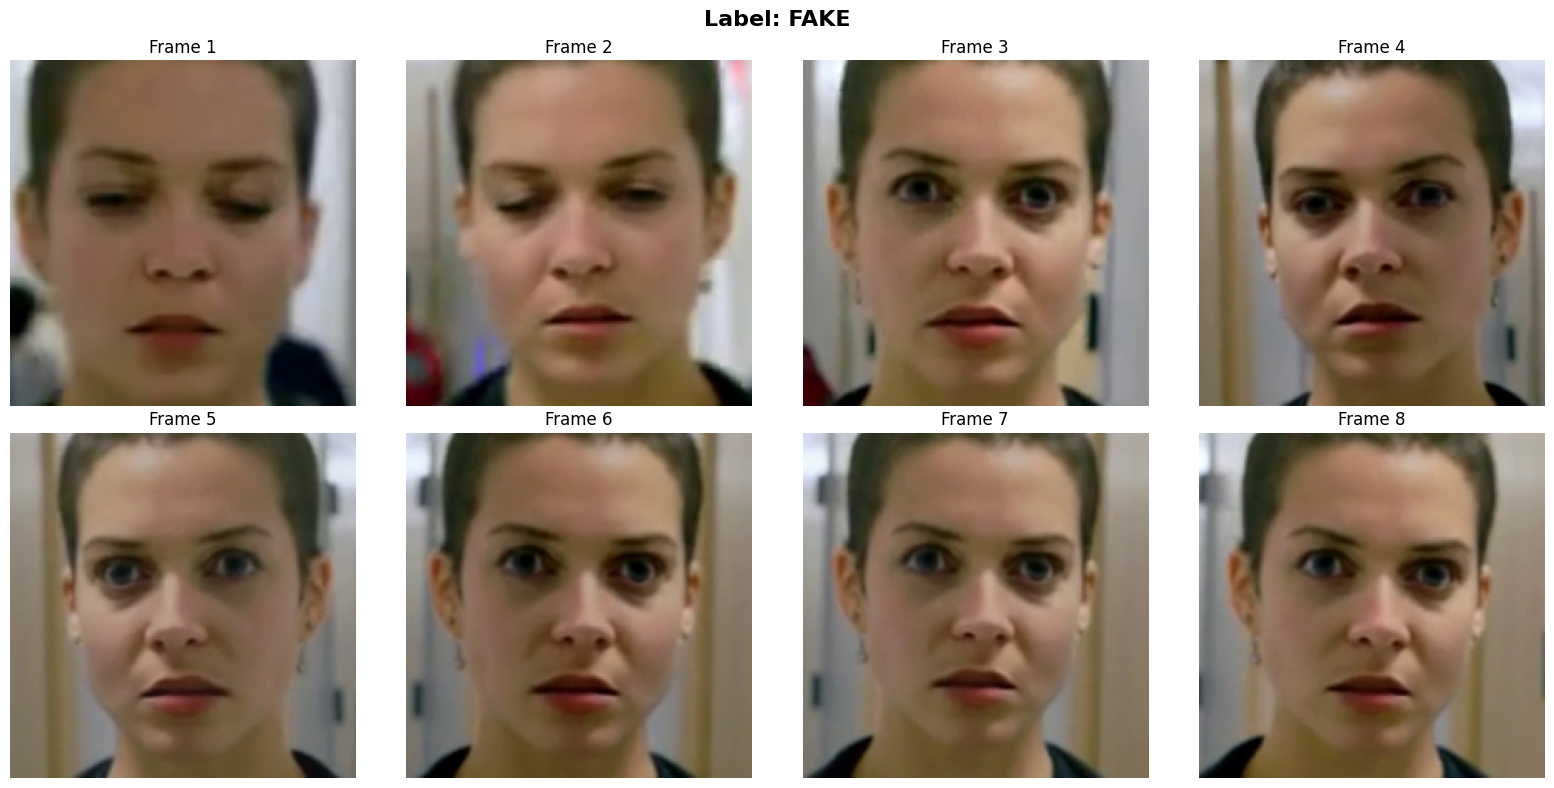

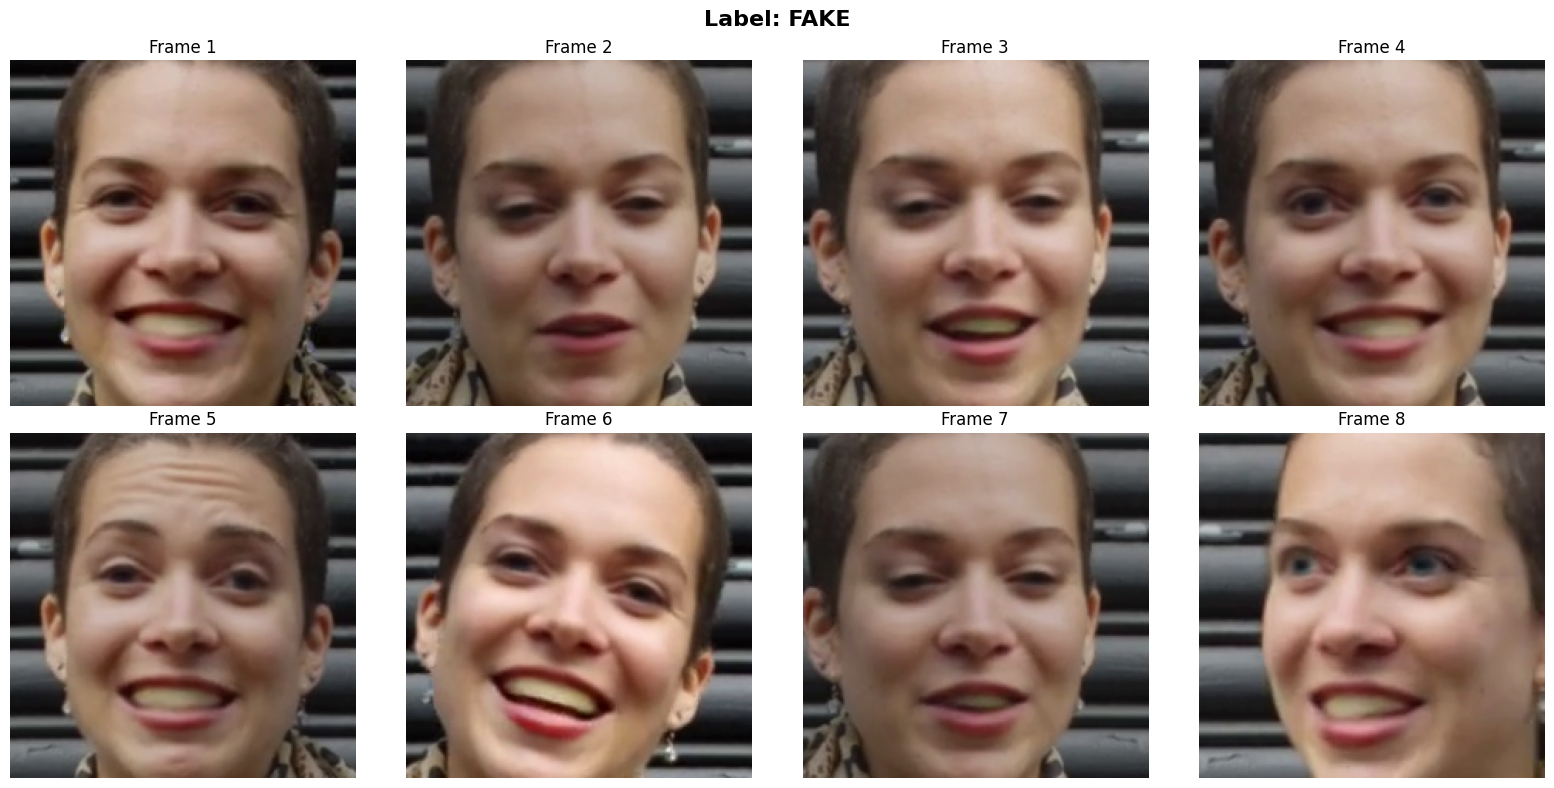

In [13]:
# Visualize a sequence
def visualize_sequence(dataset, idx):
    frames, label = dataset[idx]
    num_frames_to_show = min(8, frames.shape[0])
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(num_frames_to_show):
        frame = frames[i].permute(1, 2, 0).numpy()
        # Denormalize
        frame = frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        frame = np.clip(frame, 0, 1)
        
        axes[i].imshow(frame)
        axes[i].set_title(f'Frame {i+1}')
        axes[i].axis('off')
    
    fig.suptitle(f'Label: {"FAKE" if label == 1 else "REAL"}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Showing sample sequences...")
if len(train_dataset) > 0:
    visualize_sequence(train_dataset, 0)
    visualize_sequence(train_dataset, min(1, len(train_dataset)-1))

## Model 1: 3D ResNet

3D ResNet extends 2D convolutions to 3D for spatio-temporal feature learning.

In [14]:
class ResNet3DDetector(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Use ResNet3D from torchvision
        self.resnet3d = video_models.r3d_18(weights='DEFAULT' if pretrained else None)
        
        # Replace the final layer
        num_features = self.resnet3d.fc.in_features
        self.resnet3d.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        # x shape: (batch, num_frames, C, H, W)
        # Reshape to: (batch, C, num_frames, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        output = self.resnet3d(x)
        return output

print("3D ResNet model defined!")

3D ResNet model defined!


## Model 2: LSTM on Frame Features

Extract per-frame features with ResNet2D, then use LSTM for temporal modeling.

In [15]:
class LSTMFrameDetector(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Frame feature extractor (ResNet50)
        resnet = models.resnet50(weights='DEFAULT' if pretrained else None)
        # Remove final FC layer
        self.frame_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        # Freeze backbone
        for param in self.frame_encoder.parameters():
            param.requires_grad = False
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=2048,  # ResNet50 feature size
            hidden_size=512,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2, 256),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        # x shape: (batch, num_frames, C, H, W)
        batch_size, num_frames = x.size(0), x.size(1)
        
        # Extract frame features
        frame_features = []
        for t in range(num_frames):
            frame = x[:, t, :, :, :]  # (batch, C, H, W)
            feat = self.frame_encoder(frame).squeeze(-1).squeeze(-1)  # (batch, 2048)
            frame_features.append(feat)
        
        # Stack: (batch, num_frames, 2048)
        frame_features = torch.stack(frame_features, dim=1)
        
        # LSTM
        lstm_out, _ = self.lstm(frame_features)  # (batch, num_frames, 512*2)
        
        # Use last output
        last_output = lstm_out[:, -1, :]  # (batch, 512*2)
        
        # Classify
        output = self.classifier(last_output)
        return output

print("LSTM Frame model defined!")

LSTM Frame model defined!


## Model 3: Temporal Difference Network

Focus on frame-to-frame differences to detect temporal inconsistencies.

In [16]:
class TemporalDifferenceDetector(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Frame encoder
        resnet = models.resnet34(weights='DEFAULT' if pretrained else None)
        self.frame_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        for param in self.frame_encoder.parameters():
            param.requires_grad = False
        
        # Difference encoder
        self.diff_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Temporal aggregation
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(512 + 64, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        # x: (batch, num_frames, C, H, W)
        batch_size, num_frames = x.size(0), x.size(1)
        
        all_features = []
        
        for t in range(num_frames):
            frame = x[:, t, :, :, :]
            frame_feat = self.frame_encoder(frame).squeeze(-1).squeeze(-1)
            
            if t > 0:
                # Compute difference with previous frame
                diff = x[:, t, :, :, :] - x[:, t-1, :, :, :]
                diff_feat = self.diff_encoder(diff).squeeze(-1).squeeze(-1)
                combined = torch.cat([frame_feat, diff_feat], dim=1)
            else:
                # First frame: no difference
                combined = torch.cat([frame_feat, torch.zeros(batch_size, 64, device=x.device)], dim=1)
            
            all_features.append(combined)
        
        # Stack: (batch, num_frames, 512+64)
        all_features = torch.stack(all_features, dim=1)
        
        # Temporal conv: (batch, 512+64, num_frames)
        all_features = all_features.permute(0, 2, 1)
        temporal_feat = self.temporal_conv(all_features).squeeze(-1)
        
        output = self.classifier(temporal_feat)
        return output

print("Temporal Difference model defined!")

Temporal Difference model defined!


## Training Functions

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, desc='Training')
    for frames, labels in pbar:
        frames, labels = frames.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for frames, labels in tqdm(loader, desc='Evaluating'):
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    return running_loss / len(loader), all_preds, all_labels, all_probs

def calculate_metrics(y_true, y_pred, y_probs):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_probs)
    }

print('Functions defined!')

Functions defined!


In [18]:
def train_model(model, name, train_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    print(f"\n{'='*60}\nTraining {name}\n{'='*60}")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0.0
    best_state = None
    import time
    start = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        print(f"Train: {train_loss:.4f}, {train_acc:.2f}% | Val: {val_loss:.4f}, {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = model.state_dict().copy()
        scheduler.step()
    
    training_time = time.time() - start
    model.load_state_dict(best_state)
    _, preds, labels, probs = evaluate(model, test_loader, criterion, device)
    metrics = calculate_metrics(labels, preds, probs)
    metrics['training_time'] = training_time
    
    print(f"\n{name} Results:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}" if k != 'training_time' else f"{k}: {v:.2f}s")
    
    return model, metrics

print('Training wrapper defined!')

Training wrapper defined!


## Train All Video Models

In [19]:
results = {}
print('Starting video model training...')

Starting video model training...


In [20]:
# Model 1: 3D ResNet
resnet3d_model = ResNet3DDetector(pretrained=True)
resnet3d_trained, resnet3d_metrics = train_model(resnet3d_model, '3D_ResNet', train_loader, test_loader)
results['3D_ResNet'] = resnet3d_metrics

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to C:\Users\akshay-stu/.cache\torch\hub\checkpoints\r3d_18-b3b3357e.pth


100%|███████████████████████████████████████████████████████████████████████████████| 127M/127M [00:01<00:00, 79.5MB/s]



Training 3D_ResNet

Epoch 1/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  4.92it/s]


Train: 0.4502, 80.12% | Val: 0.1999, 93.46%

Epoch 2/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.93it/s]


Train: 0.3085, 89.34% | Val: 0.1369, 98.04%

Epoch 3/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.45it/s]


Train: 0.2687, 90.16% | Val: 0.3296, 86.93%

Epoch 4/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.73it/s]


Train: 0.1948, 93.65% | Val: 0.2151, 92.16%

Epoch 5/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.94it/s]


Train: 0.2142, 92.42% | Val: 0.0540, 100.00%

Epoch 6/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.96it/s]


Train: 0.1441, 95.70% | Val: 0.0721, 96.73%

Epoch 7/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.87it/s]


Train: 0.0823, 97.13% | Val: 0.0305, 100.00%

Epoch 8/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.80it/s]


Train: 0.0616, 98.77% | Val: 0.0290, 98.69%

Epoch 9/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.33it/s]


Train: 0.0611, 97.75% | Val: 0.0295, 98.69%

Epoch 10/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.72it/s]


Train: 0.0897, 96.52% | Val: 0.0330, 98.69%


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.88it/s]


3D_ResNet Results:
accuracy: 0.9869
precision: 1.0000
recall: 0.9750
f1: 0.9873
roc_auc: 0.9998
training_time: 597.64s


In [21]:
# Model 2: LSTM Frame
lstm_model = LSTMFrameDetector(pretrained=True)
lstm_trained, lstm_metrics = train_model(lstm_model, 'LSTM_Frame', train_loader, test_loader)
results['LSTM_Frame'] = lstm_metrics


Training LSTM_Frame

Epoch 1/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.20it/s]


Train: 0.6691, 59.43% | Val: 0.5905, 77.12%

Epoch 2/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.17it/s]


Train: 0.5074, 76.43% | Val: 0.4007, 93.46%

Epoch 3/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.04it/s]


Train: 0.3260, 86.68% | Val: 0.3647, 90.85%

Epoch 4/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.94it/s]


Train: 0.2959, 87.91% | Val: 0.3532, 90.85%

Epoch 5/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.28it/s]


Train: 0.2270, 91.19% | Val: 0.2155, 97.39%

Epoch 6/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.20it/s]


Train: 0.1823, 93.65% | Val: 0.1948, 94.77%

Epoch 7/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.21it/s]


Train: 0.1891, 92.62% | Val: 0.2083, 91.50%

Epoch 8/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.14it/s]


Train: 0.1248, 95.29% | Val: 0.1137, 96.73%

Epoch 9/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.28it/s]


Train: 0.1504, 94.67% | Val: 0.2120, 97.39%

Epoch 10/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.06it/s]


Train: 0.1359, 94.47% | Val: 0.1330, 95.42%


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.95it/s]


LSTM_Frame Results:
accuracy: 0.9542
precision: 0.9398
recall: 0.9750
f1: 0.9571
roc_auc: 0.9933
training_time: 709.88s


In [22]:
# Model 3: Temporal Difference
tempdiff_model = TemporalDifferenceDetector(pretrained=True)
tempdiff_trained, tempdiff_metrics = train_model(tempdiff_model, 'Temporal_Diff', train_loader, test_loader)
results['Temporal_Diff'] = tempdiff_metrics

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\akshay-stu/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:00<00:00, 105MB/s]



Training Temporal_Diff

Epoch 1/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.55it/s]


Train: 0.6898, 54.71% | Val: 0.6812, 52.29%

Epoch 2/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.54it/s]


Train: 0.6495, 61.27% | Val: 0.5885, 75.16%

Epoch 3/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.68it/s]


Train: 0.5628, 72.13% | Val: 0.5676, 67.32%

Epoch 4/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.69it/s]


Train: 0.5466, 72.95% | Val: 0.4968, 77.78%

Epoch 5/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.06it/s]


Train: 0.4753, 78.07% | Val: 0.3850, 88.89%

Epoch 6/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.14it/s]


Train: 0.4598, 81.76% | Val: 0.3827, 86.93%

Epoch 7/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.19it/s]


Train: 0.4183, 81.56% | Val: 0.4097, 82.35%

Epoch 8/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.20it/s]


Train: 0.4001, 82.99% | Val: 0.3553, 88.89%

Epoch 9/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.14it/s]


Train: 0.4065, 83.20% | Val: 0.4009, 85.62%

Epoch 10/10


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.02it/s]


Train: 0.3993, 84.43% | Val: 0.3618, 86.27%


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.11it/s]


Temporal_Diff Results:
accuracy: 0.8627
precision: 0.9041
recall: 0.8250
f1: 0.8627
roc_auc: 0.9447
training_time: 685.42s


## Model Comparison

In [23]:
comparison_df = pd.DataFrame(results).T.round(4)
print("\n" + "="*80)
print("VIDEO MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string())
print("="*80)

for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    best = comparison_df[metric].idxmax()
    print(f"{metric.upper()}: {best} ({comparison_df.loc[best, metric]:.4f})")


VIDEO MODEL COMPARISON
               accuracy  precision  recall      f1  roc_auc  training_time
3D_ResNet        0.9869     1.0000   0.975  0.9873   0.9998       597.6412
LSTM_Frame       0.9542     0.9398   0.975  0.9571   0.9933       709.8836
Temporal_Diff    0.8627     0.9041   0.825  0.8627   0.9447       685.4162
ACCURACY: 3D_ResNet (0.9869)
PRECISION: 3D_ResNet (1.0000)
RECALL: 3D_ResNet (0.9750)
F1: 3D_ResNet (0.9873)
ROC_AUC: 3D_ResNet (0.9998)


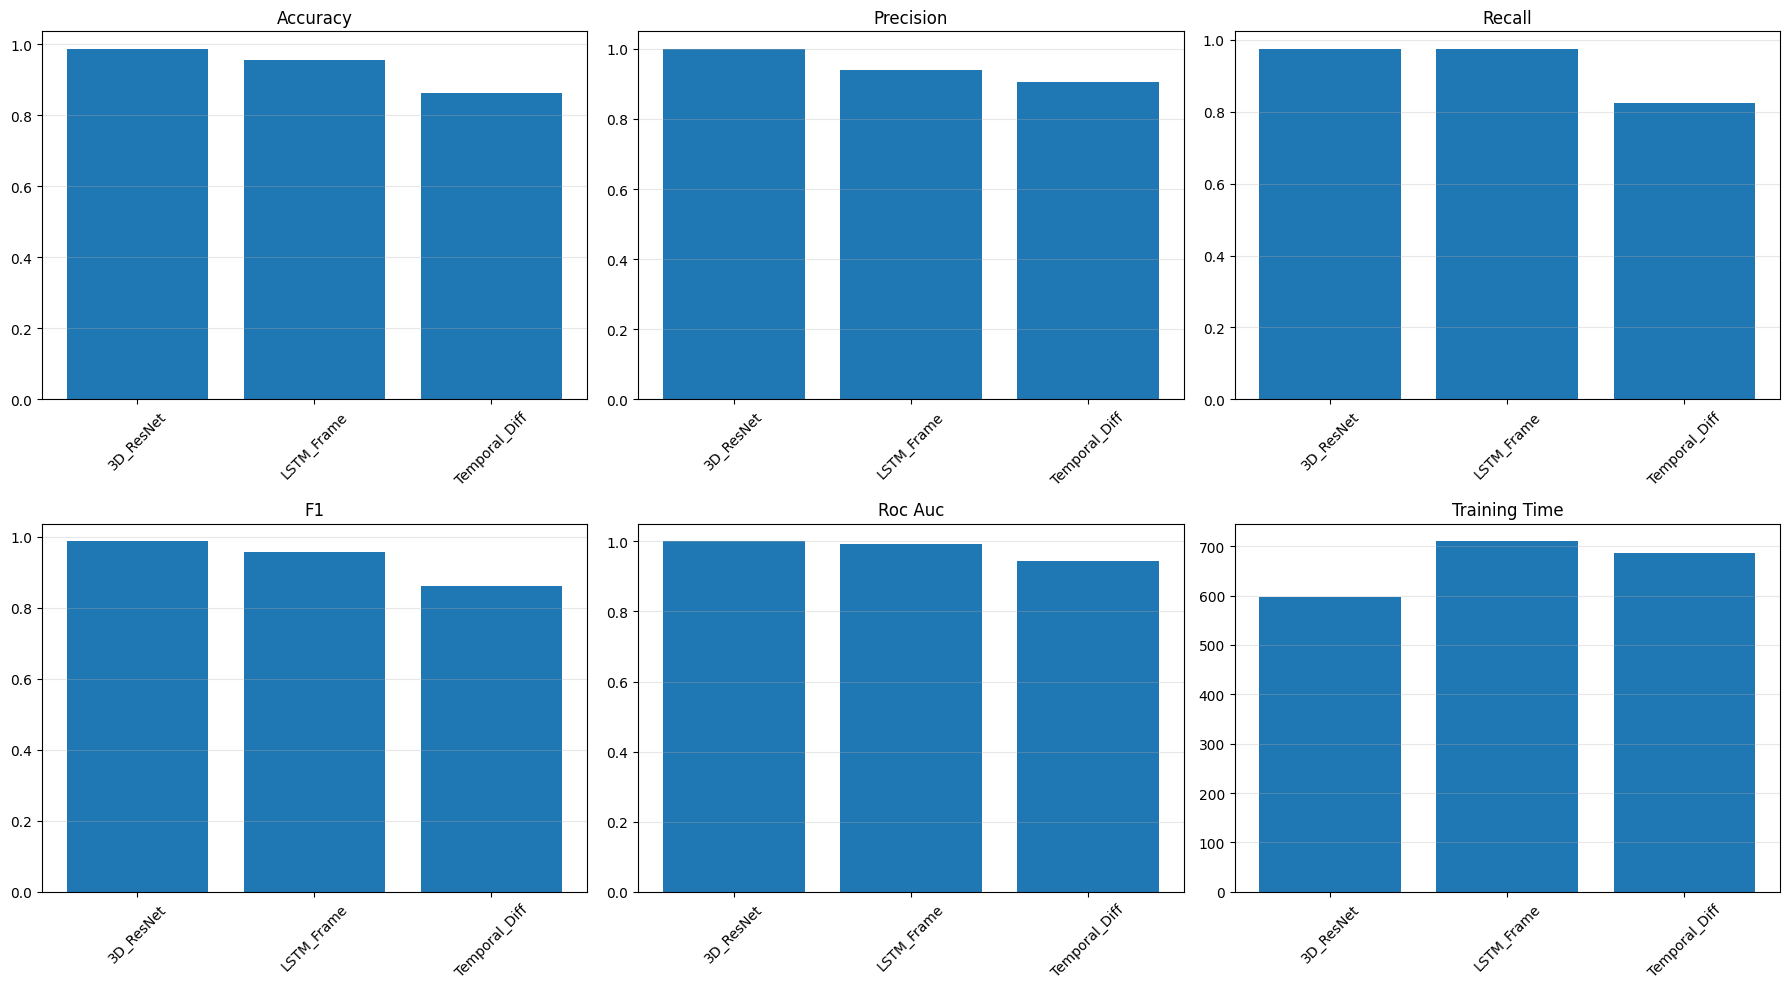

In [24]:
# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [results[m][metric] for m in results.keys()]
    ax.bar(results.keys(), values)
    ax.set_title(metric.replace('_', ' ').title())
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('video_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
comparison_df.to_csv('video_baseline_results.csv')
print('Results saved!')

Results saved!


In [26]:
# Save the best video model
best_model_name = comparison_df['accuracy'].idxmax()
print(f"Saving best model: {best_model_name}")

if best_model_name == '3D_ResNet':
    torch.save(resnet3d_trained.state_dict(), 'best_video_model_resnet3d.pth')
elif best_model_name == 'LSTM_Frame':
    torch.save(lstm_trained.state_dict(), 'best_video_model_lstm.pth')
elif best_model_name == 'Temporal_Diff':
    torch.save(tempdiff_trained.state_dict(), 'best_video_model_tempdiff.pth')

print(f"Best video model saved successfully!")

Saving best model: 3D_ResNet
Best video model saved successfully!


## Conclusion

### Key Findings:
- 3D CNNs learn spatio-temporal features jointly
- LSTM models capture long-term temporal dependencies
- Temporal differences highlight frame inconsistencies

### Next Steps:
- Combine with audio features for multimodal detection
- Implement attention mechanisms for frame importance
- Test on longer video sequences